# Importing Library 

In [1]:
!pip install wandb
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install distutils

# restart the kernal now

Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement distutils (from versions: none)
ERROR: No matching distribution found for distutils


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import wandb

# Initialize W&B
wandb.init(project="mlp-iris-experiment")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: parthivrpatel2005 (parthivrpatel2005-indian-institute-of-technology-gandhinagar) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


# Setting up Dataset

In [4]:
# Load dataset
iris = load_iris()
X = iris.data
y = iris.target.reshape(-1, 1)  # Reshape for one-hot encoding

# One-hot encoding
ohe = OneHotEncoder(sparse_output=False)
y_onehot = ohe.fit_transform(y)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_onehot, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Setiing up Model

In [5]:
# Define MLP model class
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_units, output_size):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_units)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_units, output_size)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# Instantiate the model, loss function, and optimizer
model = MLPModel(input_size=4, hidden_units=16, output_size=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training The Model

In [6]:
# Training function
def train_model(model, X_train, y_train, X_test, y_test, epochs=50, batch_size=32):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, torch.max(y_train, 1)[1])
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
        with torch.no_grad():
            val_outputs = model(X_test)
            val_loss = criterion(val_outputs, torch.max(y_test, 1)[1])
            val_losses.append(val_loss.item())
        
        wandb.log({"train_loss": loss.item(), "val_loss": val_loss.item()})
    
    return train_losses, val_losses

# Train model
train_losses, val_losses = train_model(model, X_train, y_train, X_test, y_test)

Training complete. Metrics logged to W&B.


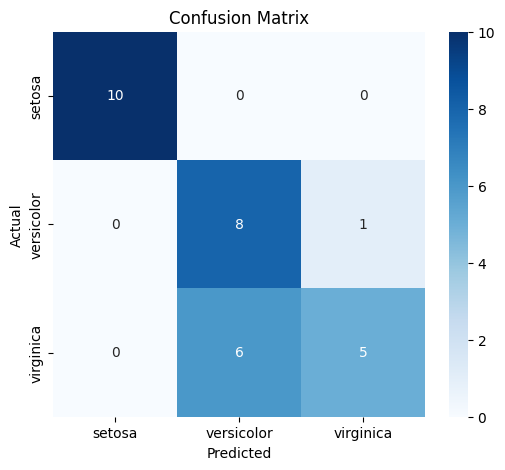

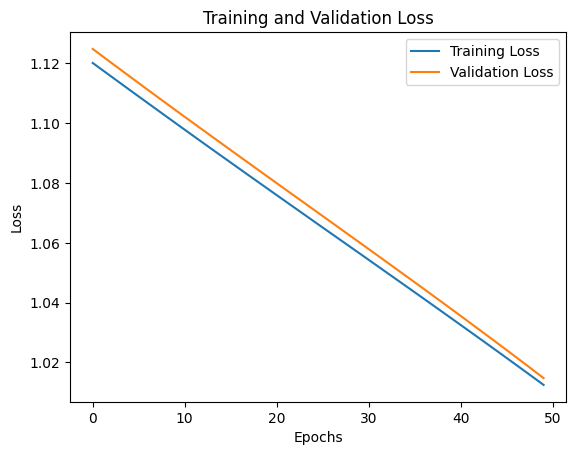

In [7]:

# Evaluate model
def evaluate_model(model, X_test, y_test):
    with torch.no_grad():
        y_pred = model(X_test)
        y_pred_classes = torch.argmax(y_pred, axis=1).numpy()
        y_true_classes = torch.argmax(y_test, axis=1).numpy()
    
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
    
    return accuracy, precision, recall, f1, y_true_classes, y_pred_classes

accuracy, precision, recall, f1, y_true_classes, y_pred_classes = evaluate_model(model, X_test, y_test)

# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")

# Plot training history
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.savefig("loss_curve.png")

# Log metrics to W&B
wandb.log({
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1,
    "loss_curve": wandb.Image("loss_curve.png"),
    "confusion_matrix": wandb.Image("confusion_matrix.png")
})

# Save model
torch.save(model.state_dict(), "mlp_iris_model.pth")

print("Training complete. Metrics logged to W&B.")